<a href="https://colab.research.google.com/github/khickey25/nlp_shap_notebooks/blob/master/08_26_2020_nlp_shap5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Dataset

### Modeling and Shap analysis on Fake news Dataset.

Text data has been saved as pickle file in Dr. Tao's google drive. Will load in data using direct link or save file to my personal drive and connect my drive to this notebook.



## TODO (11:05): 
1. Run main function to get shap values for specified explanations, analyze. Somehow return the index of one it got wrong to show as an example. (got index of incorrect answers.

## TODO 8/26/12:28 Maybe run tao's other notebook with removing of reuters and last sentence first to get cleaned datasets and save them as pickle files to be used in this notebook. 



In [ ]:


#housekeeping steps
from google.colab import drive
drive.mount('/content/drive')

!pip install shap

import pandas as pd
%tensorflow_version 1.13.1
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
import shap
import sklearn.metrics as skm
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import pprint


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394111 sha256=0b27ba63af507b24a91f3b83dd8fd0ea41b6ce6bdfa484a3c95e2c3adb0b48af
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x

Using TensorFlow backend.


In [ ]:
csv_file = "/content/drive/My Drive/test_data/fake_news_20200823.csv"
pickle_file = "/content/drive/My Drive/test_data/fake-news-20200826-cleaned.pickle"
full_df = pd.read_csv(csv_file).reset_index(drop=True)
DF = pd.read_csv(csv_file)
with open(pickle_file, 'rb') as pickle_file:
  text_train = pickle.load(pickle_file)
  y_train = pickle.load(pickle_file)
  text_test = pickle.load(pickle_file)
  y_test = pickle.load(pickle_file)
for df in [text_train, y_train, text_test, y_test]:
  df.reset_index(drop=True, inplace=True)

#scratch debugging info: not info here
a,b,c,d =  train_test_split(full_df.text, full_df.label, test_size=0.2, 
                                                    random_state=0)

In [ ]:
text_test[1]

'jeb bush cherish secret ambit potus video jeb bush upon time land far far away assum shoo gop presidenti nomin donald trump happen jeb dream presidenti glori crush fact jeb campaign troubl get mommi appear polit ad remind everyon son gop annoint trump big bulli well good thing jeb campaign circl drain die dream fulfil bizarr g rate killer hit fiction drama u govern homeland appar seri circus caught jeb admit camera like noth kill peopl televis thing though trump right thing jeb bush lacklust dork would noth laughingstock seri fact presenc would like make jump shark nevertheless high entertain realiz revel act televis drama next best thing realli potus jeb feebl mind give jeb never appear homeland never potus worri though plenti time money sure find someth construct watch video jeb confess below'

# Main

In [ ]:
#define set of helper functions

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

def read_data():
  file = "/content/drive/My Drive/test_data/fake-news-20200826-cleaned.pickle"
  with open(file, 'rb') as pickle_file:
    text_train = pickle.load(pickle_file)
    y_train = pickle.load(pickle_file)
    text_test = pickle.load(pickle_file)
    y_test = pickle.load(pickle_file)
  for df in [text_train, y_train, text_test, y_test]:
    df.reset_index(drop=True, inplace=True)

  return text_train, y_train, text_test, y_test

def preprocess_text(vocab_size, x_train_text, x_test_text, text_processor):
  """Instatiates an instance of TextPreProcessor class and transforms training 
  and testing text splits.
  Arguments:
    vocab_size {int}: Size of resulting tokenized train and test splits.
    x_train_text {pandas.Series}: Training set of text to tokenize.
    x_test_text {pandas.series}: Testing set of text to tokenize.
    text_processor {class '__main__.TextPreprocessor'}: Tokenizer to tokenize train/test text splits.
  Returns:
    X_train {numpy.ndarray}: Tokenized/OHE text training split.
    X_test {numpy.ndarray}: Tokenized/OHE text test split.
    """
  #need to remove word 'reuter' from articles
  x_train_text = x_train_text.str.replace('reuter', '')
  x_train_text = x_train_text.str.replace("via", '')
  x_test_text = x_test_text.str.replace('reuter', '')
  x_test_text = x_test_text.str.replace("via", '')



  #helper function to remove data-leakage text 
  def remove_reuter(x):
    i = x.find("-") + 2
    return x[i:]

  #CANT DO THIS BECAUSE DATA IS ALREADY FORMATTED FROM TAO TO INCLUDE reuter
  #mask_train = x_train_text[x_train_text.str.find("(Reuters") != -1].index
  #mask_test = x_test_text[x_test_text.str.find("(Reuters") != -1].index
  #x_train_text[mask_train] = x_train_text[mask].apply(remove_reuter)
  #x_test_text[mask_test] = x_test_text[mask].apply(remove_reuter)
  
  text_processor.create_tokenizer(x_train_text.iloc[:])
  X_train_tokenized = text_processor.transform_text(x_train_text) 
  X_test_tokenized = text_processor.transform_text(x_test_text)
  return X_train_tokenized, X_test_tokenized

def word_lookup_creation(processor):
  """Creates a mapping between original text and resulting words in text training split.
  Returns:
    words {dict}: Dictionary where keys are particular word in vocabulary,
                  and value is the index of said word (E.g. {'person': 1, 'gpe': 2 }).
    word_lookup {list}: List of words ordered by their index position of length vocabulary size 
                        (E.g. ['person', 'gpe',...])
                        """ 
                
  words = processor._tokenizer.word_index
  word_lookup = list()
  for i in words.keys():
      word_lookup.append(i)
  word_lookup = [''] + word_lookup
  return words, word_lookup

def create_model(input_shape):
  """Instantiates a text classifier and returns it.
  Arguments:
    input_shape {int}: Size of input array, typically the vocabulary size.
    num_tags {int}: ???
  Returns:
    model {tf.keras.Sequential}: Instantiated model to be trained.  
    """
  tf.random.set_random_seed(2020)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape = (input_shape,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

def train_and_score(model, train_data_X, train_data_y, test_data_X, test_data_y, 
                  n_epochs, batch_size):
  """Train text classifier on particular set of text and print evaluation metrics.
  Arguments:
    model {tf.keras.Sequential}: Instantiated model to be trained.
    train_data_X {numpy.ndarray}: Training text data.
    train_data_y {numpy.ndarray}: Training text labels.
    test_data_X {numpy.ndarray}: Testing text data.
    test_data_y {numpy.ndarray}: Testing text labels.
    n_epochs {int}: Number of epochs to train through.
    batch_size {int}: Batch size to train on.
    """
  model.fit(train_data_X, train_data_y, epochs=n_epochs, batch_size=batch_size, 
            validation_split=0.1)
  print('Eval loss/accuracy:{}'.format(model.evaluate(test_data_X, test_data_y,
                                                      batch_size = batch_size)))
  return model

def shap_vals_calculation(
                        train_set:np.ndarray, explanation_set:np.ndarray,
                        model:tf.python.keras.engine.sequential.Sequential):
  """Calculates shap values of corresponing text classifier.
  Arguments:
    #n_examples {int}: Number of examples to integrate over.
    #n_eplanations {int}: Number of explanations to create. 
    train_set {numpy.ndarray}: Training set.
    explanation_set {numpy.ndarray}: Testing set to create shap value explantions for.
    model {tf.keras.Sequential}: Trained model to evaluate.
  Returns:
    shap_vals {tuple}: tuple of shap values of shape:
                      ((n_explantions, vocabulary size) x # of classes)
    explainer {shap.explainer.Explainer}: Explainer object???
    """
  attrib_data = train_set
  explainer = shap.DeepExplainer(model, attrib_data)
  
  #create shap values for specific combination of genres
  shap_vals = explainer.shap_values(explanation_set)
  return shap_vals, explainer

def display_shap_figures(shap_values, test_set, word_lookup_reference):
  """Displays shap global summary plot and summary plot for each individual class/genre.
  Arguments:
    shap_values {list}: List of calculated shap values.
    test_set {numpy.ndarray}: Testing split to display explanations about.
    word_lookup_reference {list}: list of words in vocabulary ordered by index position 
                                  to display on figures.
                                  """

  shap.summary_plot(shap_values, feature_names=word_lookup_reference, 
                    class_names=y_train.columns)

  for i in range(len(shap_values)):
    print(y_test.columns[i])
    shap.summary_plot(shap_values[i], test_set[:shap_values[0].shape[0]],
                      feature_names=word_lookup_reference, 
                      class_names=y_train.columns)



In [ ]:
#main function to train model on specified datasets. 
#make list of features to remove from training sets and retrain
#model for performance comparison

def main(explained_instances, shap_n_examples=5000,
         vocab_size=2000):

  #read in presaved data
  text_train, y_train, text_test, y_test = read_data() 
  
  #instantiate Tokenizer and tokenize train and test splits.
  print("[INFO] Processing Text...\n")
  processor = TextPreprocessor(vocab_size=vocab_size)
  X_train, X_test = preprocess_text(vocab_size=vocab_size, x_train_text=text_train,
                                    x_test_text=text_test, text_processor=processor)
  
  #create word_index reference for future figures. 
  word_dict, word_lookup = word_lookup_creation(processor=processor)

  
  #instantiate and train model on train split.
  print("[INFO] Creating and Training Model...\n")
  model = create_model(input_shape=vocab_size)
  
  trained_model = train_and_score(model, train_data_X=X_train, train_data_y=y_train, 
                                  test_data_X=X_test, test_data_y=y_test,
                                  n_epochs=10, batch_size=128)
  
  #make predictions for confusion matrix and classification report
  y_pred = trained_model.predict(X_test)
  
  print("[INFO] Displaying Confusion Matrix ...\n")
  cm = skm.multilabel_confusion_matrix(y_test.values, y_pred.round(0))
  print(cm, "\n")

  incorrect = y_test[y_pred.reshape(-1).round(0) != y_test.values].index

  #calculate shap values; n_examples=50000 and n_explantions=250 
  print("[INFO] Calculating Shap Values...\n")

  explained_instances.append(incorrect[10])
  #specifying subset of testing set to include only 
  #preselected genres
  shap_vals, explainer = shap_vals_calculation(
                                      train_set=X_train[:shap_n_examples],
                                      explanation_set=X_test[[*explained_instances, *incorrect[:5]]], 
                                      model=trained_model)
  print("[INFO] Finished.")
  
  #return items for figure purposes
  return shap_vals, explainer, word_lookup, X_test, incorrect

In [ ]:
#test: explain some instance
instances_to_explain = [x for x in range(5)]
sv, explainer, wl, xt, incorrect = main(explained_instances=instances_to_explain)
shap_matrix = np.stack(sv)

[INFO] Processing Text...

[INFO] Creating and Training Model...

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 32326 samples, validate on 3592 samples
Epoch 1/10
32326/32326 [==============================] - 2s 54us/sample - loss: 0.1368 - acc: 0.9565 - val_loss: 0.0648 - val_acc: 0.9786
Epoch 2/10
32326/32326 [==============================] - 1s 43us/sample - loss: 0.0499 - acc: 0.9838 - val_loss: 0.0623 - val_acc: 0.9777
Epoch 3/10
32326/32326 [==============================] - 1s 43us/sample - loss: 0.0291 - acc: 0.9900 - val_loss: 0.0562 - val_acc: 0.9822
Epoch 4/10
32326/32326 [==============================] - 1s 42us/sample - loss: 0.0170 - acc: 0.9949 - val_loss: 0.0633 - val_acc: 0.9816
Epoch 5/10
32326/32326 [==============================] - 1s 44us/sample - loss: 0.0074 - acc: 0.9982 - val_loss: 0.0645 - val_acc: 0.9827
Epoch 6/10
3232

keras is no longer supported, please use tf.keras instead.


[INFO] Finished.


In [ ]:
print(incorrect, sv[0].shape)

Int64Index([  67,   93,  156,  159,  317,  389,  494,  574,  678,  892,
            ...
            8487, 8508, 8528, 8583, 8585, 8687, 8740, 8880, 8888, 8967],
           dtype='int64', length=133) (11, 2000)


('Article 0: PARIS (Reuters) - French President Emmanuel Macron called on all '
 'foreign powers to stop interfering in Lebanese politics and urged all '
 'Lebanese sides to fully implement a pact to keep out of regional conflicts.  '
 'For Lebanon to be protected from regional crises it s essential that all '
 'Lebanese parties and regional actors respect the principle of '
 'non-interference,  Macron said at the opening of international meeting on '
 'Lebanon in Paris.  The meeting today must show the will of international '
 'community to see the policy of regional disassociation put into place '
 'effectively by all in the country.    \n'
 'True Label: 0')


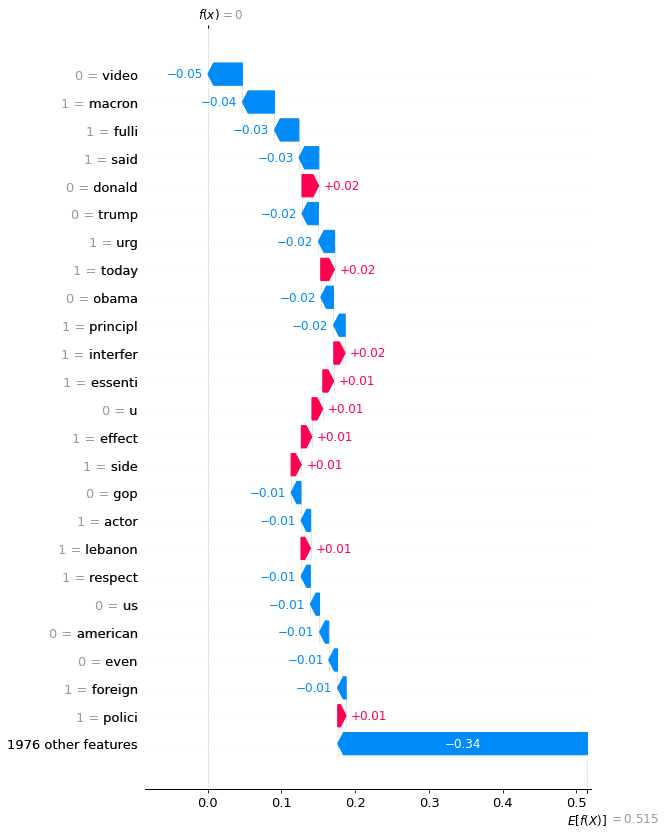

('Article 1: Jeb Bush was, once upon a time in a land far, far away, assumed '
 'to be the shoo-in for the 2016 GOP presidential nomination. Then, Donald '
 'Trump happened, and Jeb s dreams of presidential glory were crushed. In '
 'fact, Jeb s campaign is in such trouble now that he had to get his mommy to '
 'appear in a political ad reminding everyone that her son should be the GOP s '
 'annointed one, and that Trump is just a big bully.Well, it s a good thing '
 'that as Jeb s campaign circles the drain and dies, he has other dreams to '
 'fulfill. Bizarrely, it s to be a G-rated killer on the hit fictional drama '
 'about the U.S. government, Homeland.Apparently, the series The Circus caught '
 'Jeb admitting on camera that he d like nothing more than to kill people on '
 'television. The thing is, though, Trump is right about one thing. Jeb Bush '
 'is a lackluster dork who would be nothing more than a laughingstock on that '
 'series. In fact, he very presence would likely make

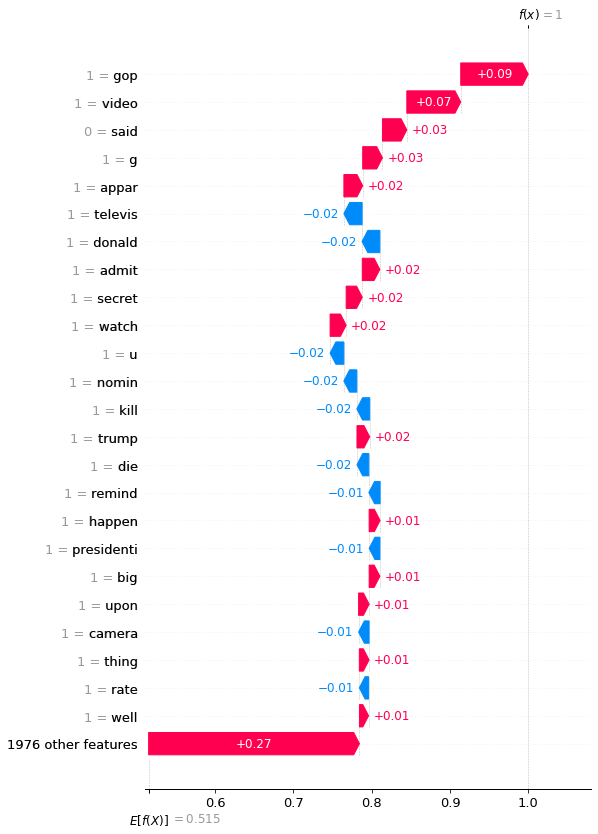

('Article 2: Remember when this would seem like a far-fetched idea? Democratic '
 'presidential front-runner Hillary Clinton said she  loves  the idea of '
 'appointing Barack Obama to the Supreme Court if she s elected president.At a '
 'campaign event in Iowa Tuesday, Mrs. Clinton told the crowd the next '
 'president may have to appoint up to three Supreme Court justices. When one '
 'attendee mentioned Mr. Obama as a contender, she seemed excited by the '
 'recommendation. Wow, what a great idea. No one has ever suggested that to '
 'me, I love that, wow,  Mrs. Clinton said.  He may have a few other things to '
 'do, but I tell you, that s a great idea. I mean, he s brilliant, he can set '
 'forth an argument and he was a law professor,  she added.  So he s got all '
 'the credentials, but we would have to get a Democratic Senate to get him '
 'confirmed. Via: Washington Times \n'
 'True Label: 1')


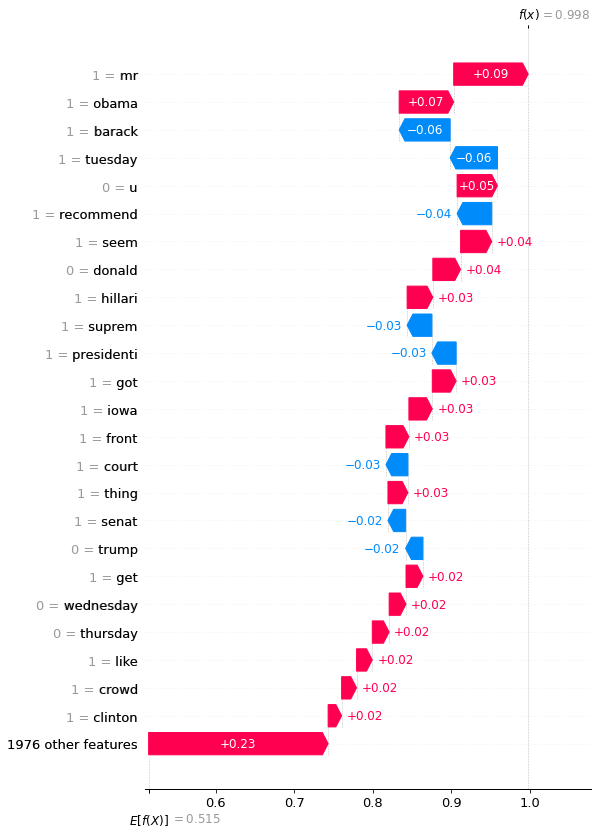

('Article 3: When President Donald Trump visited the CIA Saturday, he had '
 'hoped that CIA Director Mike Pompeo would accompany him. But when Trump '
 'arrived at the Langley, Virginia, headquarters of the Agency, he was instead '
 'accompanied by Congressman Mike Pompeo.Here s what happened between Schumer '
 'and Cotton on Friday:The Senate reconvened after the inaugural ceremonies on '
 'Friday, with Pompeo s nomination set to come up at 4:50pm. Cotton angrily '
 'confronted Schumer about his broken promise. According to witnesses, Schumer '
 'told Cotton to lower his voice and asked him move off of the Senate floor to '
 'an adjacent hallway for a private discussion.  We need to take this out into '
 'the hallway,  Schumer said. Cotton walked with Schumer but loudly rejected '
 'his first request.  Don t tell me to lower my voice!  he shouted, with an '
 'additional salty admonition tacked on for emphasis. Burr and Cornyn were '
 'present, as was Senator Mark Warner, ranking memb

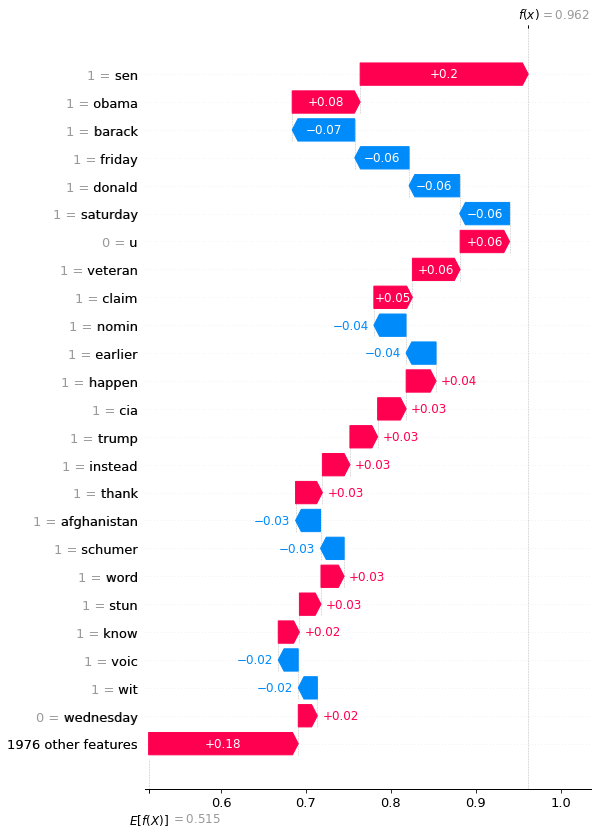

('Article 4: Maury is perhaps one of the trashiest shows on television today. '
 'It s right in line with the likes of the gutter trash that is Jerry '
 'Springer, and the fact that those shows are still on the air with the shit '
 'they air really is a sad testament to what Americans find to be '
 'entertaining. However, Maury really crossed the line with a Facebook post '
 'regarding one of their guest s appearance with a vile, disgusting caption on '
 'Tuesday evening.There was a young woman on there doing one of their episodes '
 'regarding the paternity of her child. However, on the page, the show posted '
 'an image of the woman, who happens to bear a striking resemblance to Senator '
 'and presidential candidate Ted Cruz. The caption from the Maury Show page '
 'read: The Lie Detector Test determined .that was a LIE!  Ted Cruz is just '
 'NOT that SEXY! As if that weren t horrible enough, the caption underneath '
 'the Imgur upload reads,  Ted Cruz in drag on Maury. Here is an i

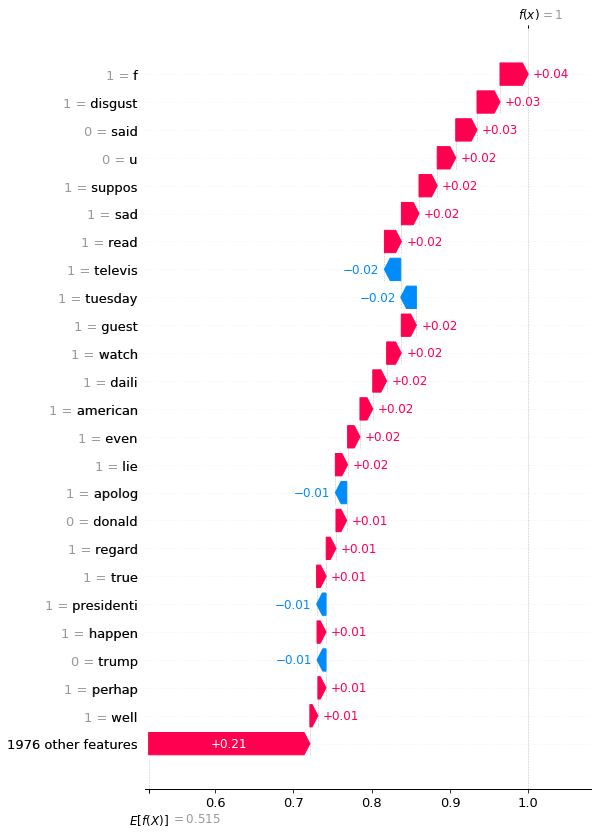

('Article 5: SAN FRANCISCO (Reuters) - A U.S. senator and civil groups '
 'critical of surveillance practices on Friday called on the government to '
 'release a 2015 order by a secret court directing Yahoo to scan all its '
 'users’ incoming email, saying it appeared to involve new interpretations of '
 'at least two important legal issues. Their concerns center on the nature of '
 'the technical assistance the court required Yahoo to provide and the scope '
 'of the search that legal experts said appeared to cover the Silicon Valley '
 'internet company’s entire network. Yahoo installed a custom software program '
 'to search messages to hundreds of millions of accounts at the behest of U.S. '
 'intelligence officials with an order from the Foreign Intelligence '
 'Surveillance Court, a secret tribunal, Reuters reported on Tuesday. They '
 'were looking for messages containing a single piece of digital content, '
 'three former employees and a fourth person apprised of the events tol

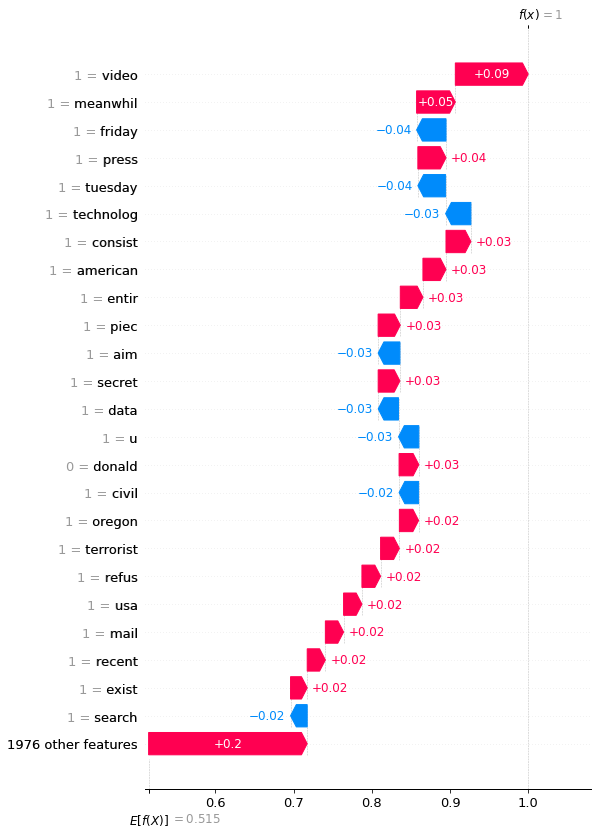

('Article 6: Just when you find yourself wondering if the world has gone '
 'completely mad you read a story like this that confirms that indeed, it has '
 'Gov. Jerry Brown is allowing parole for a transgender inmate who is trying '
 'to force California to become the first state to pay for sex reassignment '
 'surgery.A federal judge in April ordered the state to provide the surgery, '
 'which had been scheduled for July. It was delayed after the state '
 'appealed.The governor s office said Friday that Brown was taking no action '
 'on the Board of Parole Hearings  recommendation to release Michelle-Lael '
 'Norsworthy, which means her parole will proceed.The decision makes it less '
 'likely that the 51-year-old will be able to have surgery funded by the '
 'prison before she is released. Parole board spokesman Luis Patino said it '
 'usually takes about a week for an inmate to be released after the governor '
 'allows a parole to proceed.Brown decided Norsworthy is no longer dange

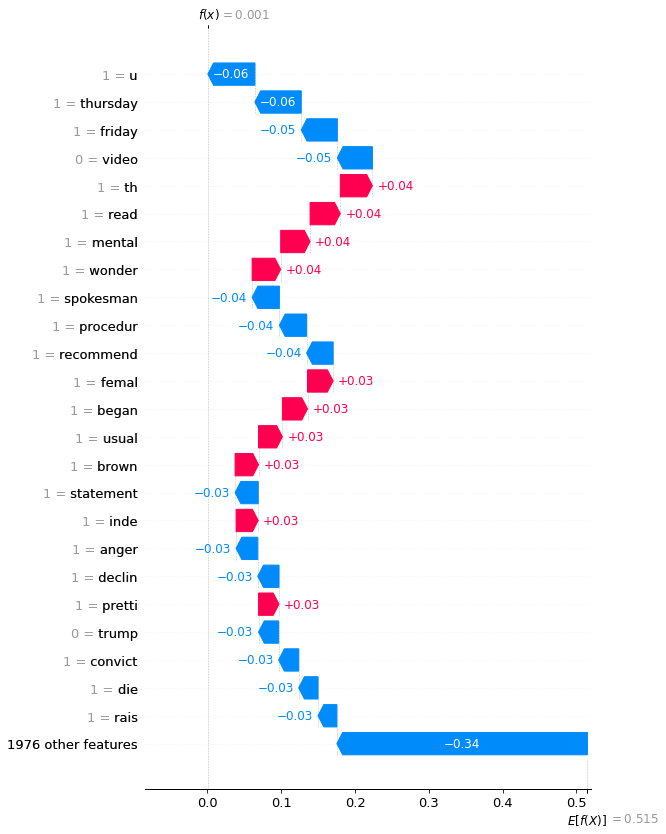

('Article 7: Paul Ryan is learning quickly that John Boehner had good reason '
 'to cry all the time. The Speaker of the House of Representatives is the '
 'leader of his or her party. The third most powerful person in the free '
 'world. Speakers enjoy visibility and influence above and beyond any other '
 'representative in the chamber.That s how it used to be, anyway, when the '
 'speaker was a position respected by their own party. From the days of Tip O '
 'Neil and Tom Foley to Dennis Hastert and even Newt Gingrich, the Speaker of '
 'the House commanded respect.Unfortunately for Republicans, their base began '
 'to die off and they needed to replenish, so they decided to go ahead and '
 'back the super-zealots of the Tea Party, who have now morphed into the  '
 'Freedom Caucus,  and things will never be the same. There have always been '
 'fringe-right congressmen and women. Michele Bachmann wasn t the first '
 'complete moron to deny science on the house floor, but she was one 

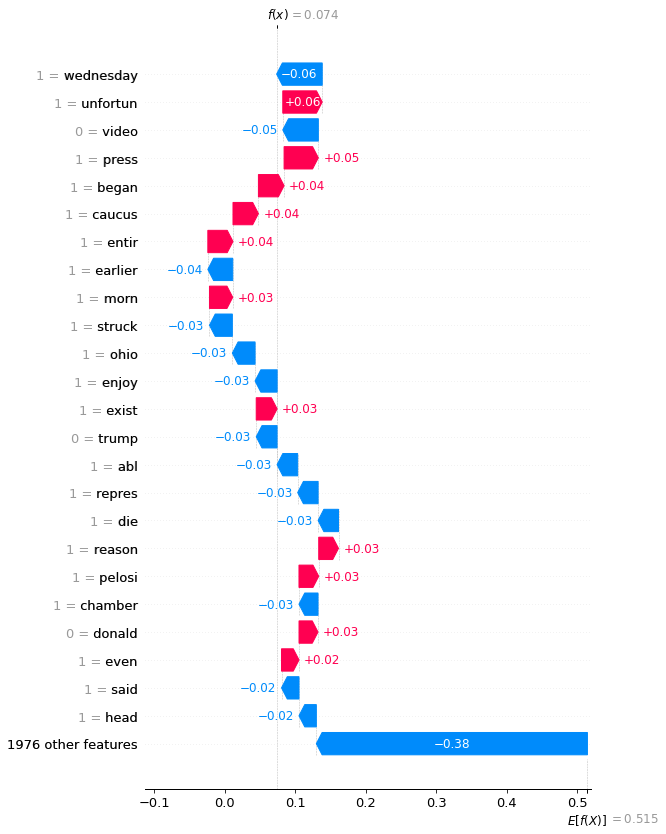

('Article 8: After going through a week reminiscent of Napoleon’s at Waterloo, '
 'Republican presidential nominee Donald Trump will likely claim that Indiana '
 'Governor Mike Pence’s performance in Tuesday’s vice-presidential debate gave '
 'a boost to their campaign.  That would be overstating it.  The debate '
 'probably changed few votes in the 2016 presidential election. The question '
 'is whether it will change any votes in the 2020 contest.  In this year’s '
 'race, the debate was something of a wash. Virginia Senator Tim Kaine, the '
 'Democratic vice-presidential nominee, came across like an over-caffeinated '
 'prosecutorial chipmunk – interrupting at every occasion. And at moments that '
 'weren’t occasions at all.  A gentle soul who’s uncomfortable in the '
 'attack-dog role that the Clinton campaign has assigned him, Kaine plainly '
 'overcompensated by piping up whenever Pence sought to evade debate moderator '
 'Elaine Quijano’s questions.  And because Pence spent the 

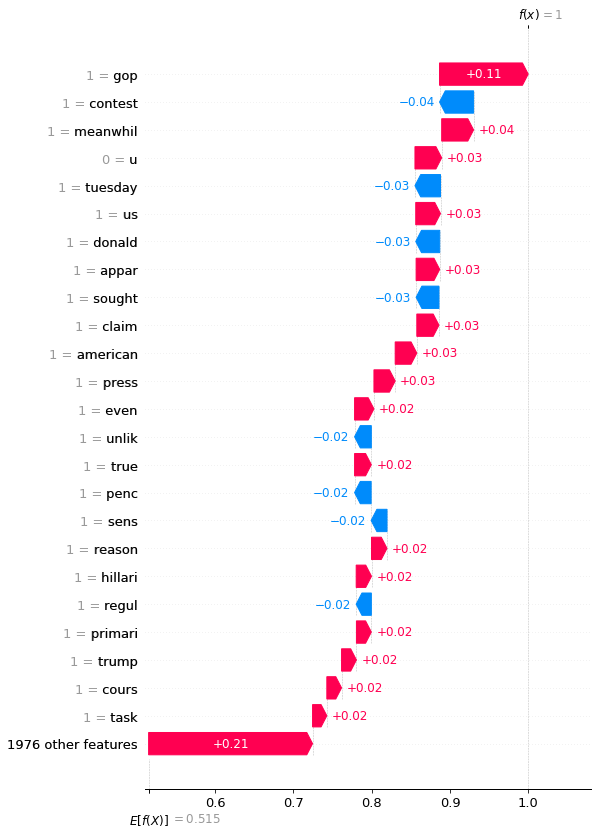

('Article 9: SAN FRANCISCO (Reuters) - LinkedIn cofounder Reid Hoffman said on '
 'Tuesday that Republican presidential candidate Donald Trump would have a '
 '“terrifying” effect on domestic and foreign policy if elected. The comments '
 'came one day after Hoffman published an article on Medium.com pledging '
 'support to a CrowdPac crowdfunding campaign that promises to donate to '
 'veterans causes if Trump releases his tax returns.  Hoffman said in his '
 'article that he will match five times the crowdfunded amount to donate up to '
 '$5 million. The campaign has raised more than $90,000. Hoffman told a crowd '
 'at TechCrunch Disrupt 2016 in San Francisco that he was “in denial” about '
 'the possibility of a Trump presidency but encouraged by efforts to hold the '
 'candidate accountable.\xa0 Trump’s campaign did not immediately respond to a '
 'request for comment.  Trump is facing criticism for not releasing tax '
 'returns, a political practice that is not required by law bu

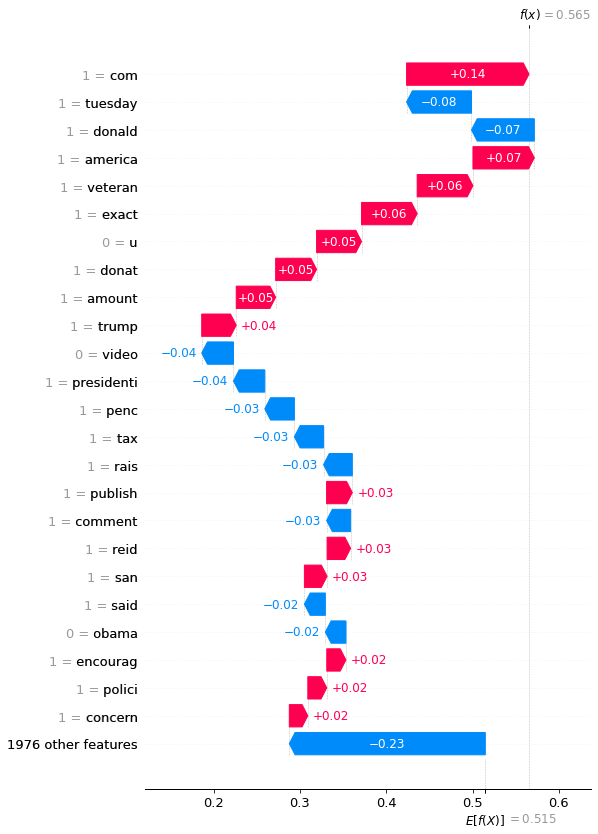

('Article 10: It s a snub don t believe the pundits on this one. It s concern '
 'over the Iran deal that s got Saudi and other leaders so peeved at Obama. He '
 'might be able to get away with talking out of both sides of his mouth with '
 'everyone else but not with the Saudis who re having nothing to do with this '
 'upcoming summit. The White House was scrambling Monday to put a positive '
 'face on an upcoming summit of Persian Gulf states after learning leaders '
 'from four of the six invited nations are expected to skip.While those '
 'nations are still sending representatives to the summit being hosted by '
 'President Obama later this week at Camp David, the absence of crucial heads '
 'of state   notably, Saudi Arabia s new king   could present an awkward '
 'situation for the administration.In a statement Sunday, Saudi Foreign '
 'Minister Adel al-Jubeir said Thursday s summit coincides with a humanitarian '
 'cease-fire in Yemen, where a Saudi-led coalition is fighting Shi

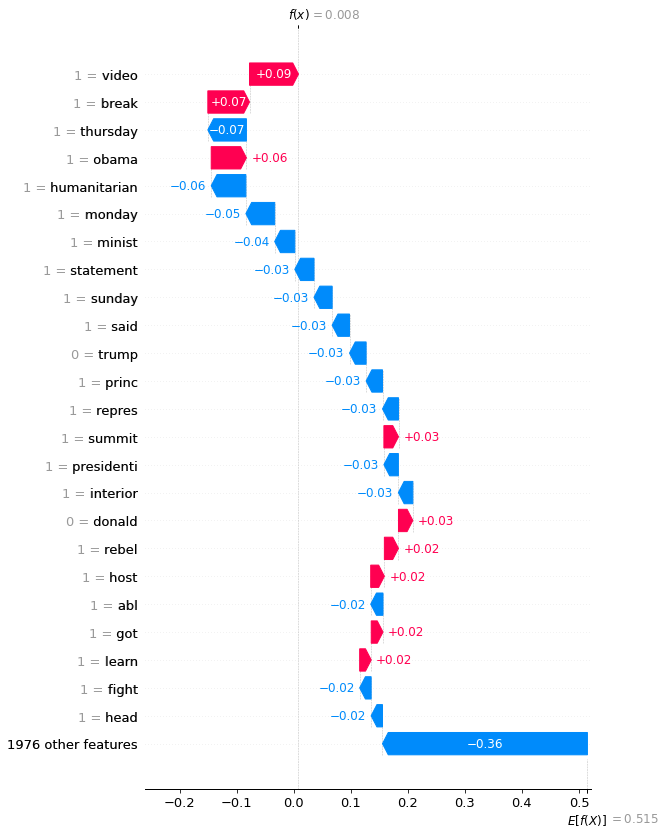

In [ ]:
shap.initjs()
import pprint as pp

#drop word reuter for debug purposes
for i, n in enumerate([*instances_to_explain, *incorrect[:5]]):
  pp.pprint(f"Article {i}: {b.iloc[n]} \nTrue Label: {y_test.iloc[n]}")
  shap.waterfall_plot(explainer.expected_value[0], shap_matrix[0][i], features = xt[n],
                      feature_names=wl[:2000],
                    max_display=25)
#shap_matrix shape: expected value X ith example X features (words in text)